## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

#import tensorflow as tf
import keras

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
33360,00008745_019.png,No Finding,19,8745,46,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008745_019.png
59381,00014675_025.png,Effusion|Pneumothorax,25,14675,67,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014675_025.png
95743,00025189_001.png,No Finding,1,25189,51,F,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00025189_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

from itertools import chain

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [4]:
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df['Number of Diseases'] = all_xray_df['Finding Labels'].map(lambda finding: 0 if finding == 'No Finding' else finding.count('|') + 1)

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda b: 'True' if b else 'False')
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'Number of Diseases', 'pneumonia_class'],
      dtype='object')

In [6]:
def find_image(image_file):
    for suffix in range(1, 13):
        zeros = '00' if suffix < 10 else '0'
        path = f'/data/images_{zeros}{suffix}/images'
        image_path = f'{path}/{image_file}'
        if os.path.exists(image_path): return image_path
    return None

all_xray_df['Image File'] = all_xray_df['Image Index'].map(find_image)

In [7]:
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases,pneumonia_class,Image File
63405,00015647_015.png,Infiltration,15,15647,45,F,AP,3056,2544,0.139,...,1,0,0,0,0,0,0,1,False,/data/images_007/images/00015647_015.png
23449,00006214_004.png,No Finding,4,6214,51,F,PA,2048,2500,0.171,...,0,0,1,0,0,0,0,0,False,/data/images_003/images/00006214_004.png
62898,00015556_006.png,Emphysema,6,15556,56,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,1,False,/data/images_007/images/00015556_006.png
97543,00025746_014.png,Atelectasis,14,25746,59,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,False,/data/images_011/images/00025746_014.png
72312,00017816_000.png,No Finding,0,17816,21,M,PA,2822,2869,0.143,...,0,0,1,0,0,0,0,0,False,/data/images_008/images/00017816_000.png


## Create your training and testing data:

In [8]:
from sklearn.model_selection import train_test_split

FACTOR = 5 #10

def create_splits(train_percent = 0.80):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    pneumonia_df = all_xray_df[all_xray_df.Pneumonia == 1]
    non_pneumonia_df = all_xray_df[all_xray_df.Pneumonia == 0]
    n = all_xray_df.shape[0]
    print('Pneumonia cases: {} ({:.2f}%)'.format(pneumonia_df.shape[0], 100. * pneumonia_df.shape[0] / n))
    print('Non-pneumonia cases: {} ({:.2f}%)'.format(non_pneumonia_df.shape[0], 100. * non_pneumonia_df.shape[0] / n))
    train_indexes, val_indexes = train_test_split(np.arange(pneumonia_df.shape[0]), train_size = train_percent, random_state = 42)
    train_data = pneumonia_df.iloc[train_indexes]
    val_data = pneumonia_df.iloc[val_indexes]
    n_train_data = train_data.shape[0]
    non_pneumonia_indexes = np.random.choice(non_pneumonia_df.shape[0], pneumonia_df.shape[0] * FACTOR, replace = False)
    train_data = train_data.append(non_pneumonia_df.iloc[non_pneumonia_indexes[:n_train_data * FACTOR]])
    val_data = val_data.append(non_pneumonia_df.iloc[non_pneumonia_indexes[n_train_data * FACTOR:]])
    train_data = train_data.sample(frac = 1).reset_index(drop = True)
    val_data = val_data.sample(frac = 1).reset_index(drop = True)
    return train_data, val_data

train_data, val_data = create_splits()

print('Due to the very imbalance nature of the pneumonia cases versus non-pneumonia cases (1.28:98.72),')
print(f'I decided to balance both the training dataset and the validation dataset with a proportion of (1:{FACTOR}).\n')
print('{} (pneumonia train) + {} (non_pneumonia train) = {} (all train)'.format(
    train_data[train_data.Pneumonia == 1].shape[0], 
    train_data[train_data.Pneumonia == 0].shape[0], 
    train_data.shape[0]))
print('{} (pneumonia val) + {} (non_pneumonia val) = {} (all val)'.format(
    val_data[val_data.Pneumonia == 1].shape[0], 
    val_data[val_data.Pneumonia == 0].shape[0], 
    val_data.shape[0]))
train_data.sample(10)

Pneumonia cases: 1431 (1.28%)
Non-pneumonia cases: 110689 (98.72%)
Due to the very imbalance nature of the pneumonia cases versus non-pneumonia cases (1.28:98.72),
I decided to balance both the training dataset and the validation dataset with a proportion of (1:5).

1144 (pneumonia train) + 5720 (non_pneumonia train) = 6864 (all train)
287 (pneumonia val) + 1435 (non_pneumonia val) = 1722 (all val)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Diseases,pneumonia_class,Image File
4696,00027651_004.png,Consolidation|Infiltration,4,27651,56,M,PA,2544,3056,0.139000,...,1,0,0,0,0,0,0,2,False,/data/images_011/images/00027651_004.png
1097,00015406_008.png,No Finding,8,15406,38,M,AP,2500,2048,0.168000,...,0,0,1,0,0,0,0,0,False,/data/images_007/images/00015406_008.png
3087,00026196_001.png,Mass|Nodule|Pneumonia,1,26196,64,M,PA,2992,2991,0.143000,...,0,1,0,1,0,1,0,3,True,/data/images_011/images/00026196_001.png
873,00030464_000.png,Cardiomegaly|Effusion,0,30464,47,M,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,2,False,/data/images_012/images/00030464_000.png
6726,00010060_026.png,No Finding,26,10060,58,F,AP,2500,2048,0.168000,...,0,0,1,0,0,0,0,0,False,/data/images_005/images/00010060_026.png
5449,00000879_000.png,No Finding,0,879,60,F,PA,2762,2665,0.143000,...,0,0,1,0,0,0,0,0,False,/data/images_001/images/00000879_000.png
5084,00017356_004.png,Infiltration,4,17356,29,F,AP,2500,2048,0.168000,...,1,0,0,0,0,0,0,1,False,/data/images_008/images/00017356_004.png
806,00004193_000.png,No Finding,0,4193,37,M,PA,2500,2048,0.171000,...,0,0,1,0,0,0,0,0,False,/data/images_003/images/00004193_000.png
273,00004822_005.png,Infiltration|Pneumonia,5,4822,33,M,PA,2992,2991,0.143000,...,1,0,0,0,0,1,0,2,True,/data/images_003/images/00004822_005.png
3361,00027983_000.png,No Finding,0,27983,59,M,PA,2936,2948,0.143000,...,0,0,1,0,0,0,0,0,False,/data/images_011/images/00027983_000.png


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 64

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    rescale = 1. # 1. / 255
    idg = ImageDataGenerator(rescale = rescale, horizontal_flip = True, vertical_flip = False,
                            height_shift_range = 0.1, width_shift_range = 0.1, rotation_range = 20,
                            shear_range = 0.1, zoom_range = 0.1)
    return idg


def make_train_gen():
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    idg = my_image_augmentation()
    train_gen = idg.flow_from_dataframe(dataframe = train_data, directory = None, 
                                        x_col = 'Image File', y_col = 'pneumonia_class', class_mode = 'binary', 
                                        target_size = IMG_SIZE, batch_size = BATCH_SIZE)
    return train_gen


def make_val_gen():
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_idg = ImageDataGenerator()
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, directory = None, 
                                      x_col = 'Image File', y_col = 'pneumonia_class', class_mode = 'binary', 
                                      target_size = IMG_SIZE, batch_size = BATCH_SIZE)
    return val_gen

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen()
val_gen = make_val_gen()
valX, valY = val_gen.next()

Found 6864 validated image filenames belonging to 2 classes.
Found 1722 validated image filenames belonging to 2 classes.


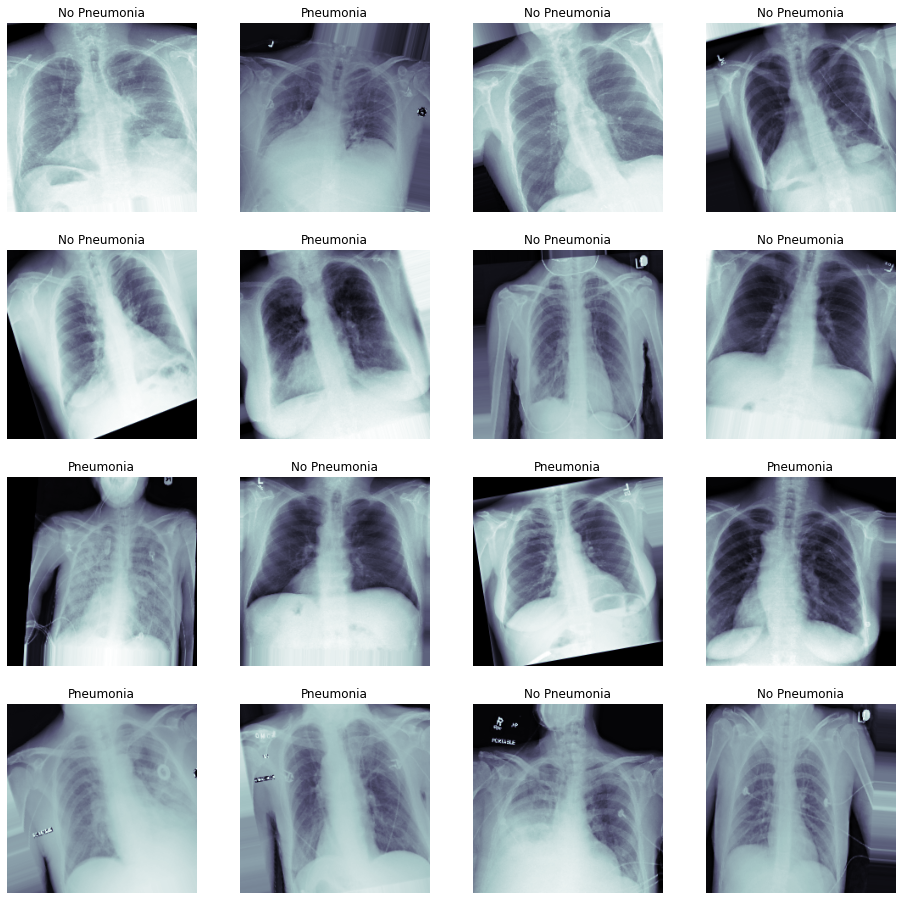

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
from keras.applications.vgg16 import VGG16
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    vgg_model = VGG16(include_top=True, weights='imagenet')
    vgg_model.summary()
    return vgg_model

vgg_model = load_pretrained_model()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    new_model = Sequential()
    for layer in vgg_model.layers[:-1]:
        layer.trainable = False
        new_model.add(layer)
    new_model.add(Dense(1024 * 2, activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.25))
    new_model.add(Dense(1, activation='sigmoid'))
    new_model.summary()
    
    return new_model
    
model = build_my_model(vgg_model)    
    
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [14]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

weight_path = 'best_weights.hdf5'
monitor_var = 'val_binary_accuracy'

checkpoint = keras.callbacks.ModelCheckpoint(
    weight_path, monitor = monitor_var, verbose = 1, save_best_only = True,
    save_weights_only = True, mode = 'auto')

early = keras.callbacks.EarlyStopping(
    monitor = monitor_var, min_delta = 0, patience = 20, verbose = 1, mode = 'auto',
    baseline = None, restore_best_weights = True)

callbacks_list = [checkpoint, early]

### Start training! 

In [15]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

optimizer = keras.optimizers.Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
model.compile(optimizer = optimizer, loss = loss, metrics=metrics)

history = model.fit_generator(train_gen, validation_data = (valX, valY), epochs = 200, callbacks = callbacks_list)

Epoch 1/200
108/108 [==============================] - 192s 2s/step - loss: 0.4956 - binary_accuracy: 0.8100 - val_loss: 0.2666 - val_binary_accuracy: 0.9375

Epoch 00001: val_binary_accuracy improved from -inf to 0.93750, saving model to best_weights.hdf5
Epoch 2/200
108/108 [==============================] - 182s 2s/step - loss: 0.4550 - binary_accuracy: 0.8260 - val_loss: 0.2763 - val_binary_accuracy: 0.9219

Epoch 00002: val_binary_accuracy did not improve from 0.93750
Epoch 3/200
108/108 [==============================] - 181s 2s/step - loss: 0.4497 - binary_accuracy: 0.8279 - val_loss: 0.2921 - val_binary_accuracy: 0.9219

Epoch 00003: val_binary_accuracy did not improve from 0.93750
Epoch 4/200
108/108 [==============================] - 180s 2s/step - loss: 0.4376 - binary_accuracy: 0.8287 - val_loss: 0.4133 - val_binary_accuracy: 0.9219

Epoch 00004: val_binary_accuracy did not improve from 0.93750
Epoch 5/200
108/108 [==============================] - 180s 2s/step - loss: 0.43

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = BATCH_SIZE, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
## what other performance statistics do you want to include here besides AUC? 
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def calc_f1(prec, recall):
    return 2 * (prec * recall) / (prec + recall)
    
#Also consider plotting the history of your model training:

def plot_loss_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#     plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
#     plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    
def plot_acc_history(history):
    N = len(history.history["binary_accuracy"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")


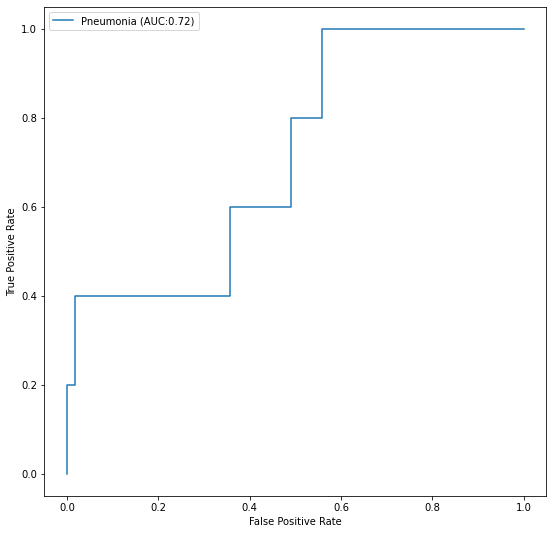

In [18]:
plot_auc(valY, pred_Y)

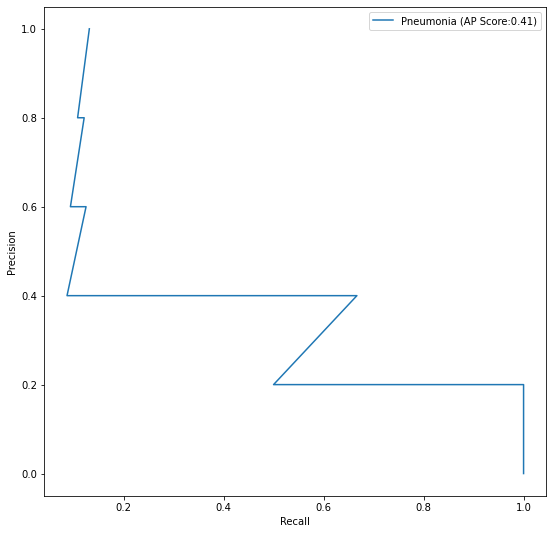

In [19]:
plot_pr(valY, pred_Y)

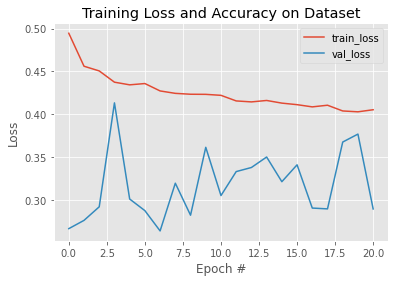

In [20]:
## plot figures

# Todo

plot_loss_history(history)

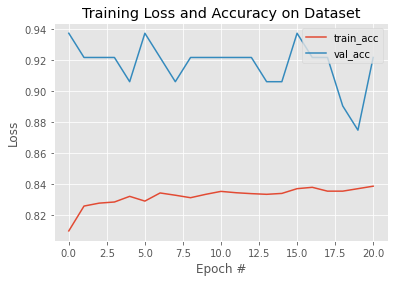

In [21]:
plot_acc_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [22]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [23]:
print(precision.shape, recall.shape, thresholds.shape)

(39,) (39,) (38,)


In [24]:
# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = np.nanargmin(np.abs(precision[:-1] - precision_value))
#print(idx, precision[idx])
threshold1 = thresholds[idx]
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(threshold1))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.6666666666666666
Recall is: 0.4
Threshold is: 0.32287744
F1 Score is: 0.5


In [25]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = np.nanargmin(np.abs(recall[:-1] - recall_value))
threshold2 = thresholds[idx]
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(threshold2))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.10810810810810811
Recall is: 0.8
Threshold is: 0.09243534
F1 Score is: 0.19047619047619047


In [26]:
def compute_accuracy(threshold):
    t = (pred_Y[:, 0] > threshold)
    compare_t = (t == valY)
    return len(compare_t[compare_t]) / pred_Y.shape[0]

In [27]:
print('Accuracy at threshold 1 ({:.4f}): {:.4f}'.format(threshold1, compute_accuracy(threshold1)))
print('Accuracy at threshold 2 ({:.4f}): {:.4f}'.format(threshold2, compute_accuracy(threshold2)))

Accuracy at threshold 1 (0.3229): 0.9219
Accuracy at threshold 2 (0.0924): 0.4844


In [28]:
f1 = np.array([calc_f1(prec, rec) for prec, rec in zip(precision, recall)])
print('F1-scores:\n{}\n'.format(f1))

max_index = np.nanargmax(f1)
YOUR_THRESHOLD = thresholds[max_index + 1]
max_f1 = f1[max_index]
print('Optimal threshold: {:.4f}, Maximum F1-score: {:.4f}'.format(YOUR_THRESHOLD, max_f1))

F1-scores:
[0.23255814 0.19047619 0.19512195 0.2        0.20512821 0.21052632
 0.16216216 0.16666667 0.17142857 0.17647059 0.18181818 0.1875
 0.19354839 0.2        0.20689655 0.14285714 0.14814815 0.15384615
 0.16       0.16666667 0.17391304 0.18181818 0.19047619 0.2
 0.21052632 0.22222222 0.23529412 0.25       0.26666667 0.28571429
 0.30769231 0.33333333 0.36363636 0.4        0.44444444 0.5
 0.28571429 0.33333333 0.        ]

Optimal threshold: 0.4412, Maximum F1-score: 0.5000


In [29]:
print('Accuracy at optimal threshold ({:.4f}): {:.4f}'.format(YOUR_THRESHOLD, compute_accuracy(YOUR_THRESHOLD)))

Accuracy at optimal threshold (0.4412): 0.9375


In [30]:
accuracies = np.array([compute_accuracy(t) for t in thresholds])
max_acc_index = np.nanargmax(accuracies)
print('Maximum accuracy at threshold {:.4f}: {:.4f}'.format(thresholds[max_acc_index], accuracies[max_acc_index]))

Maximum accuracy at threshold 0.3193: 0.9375


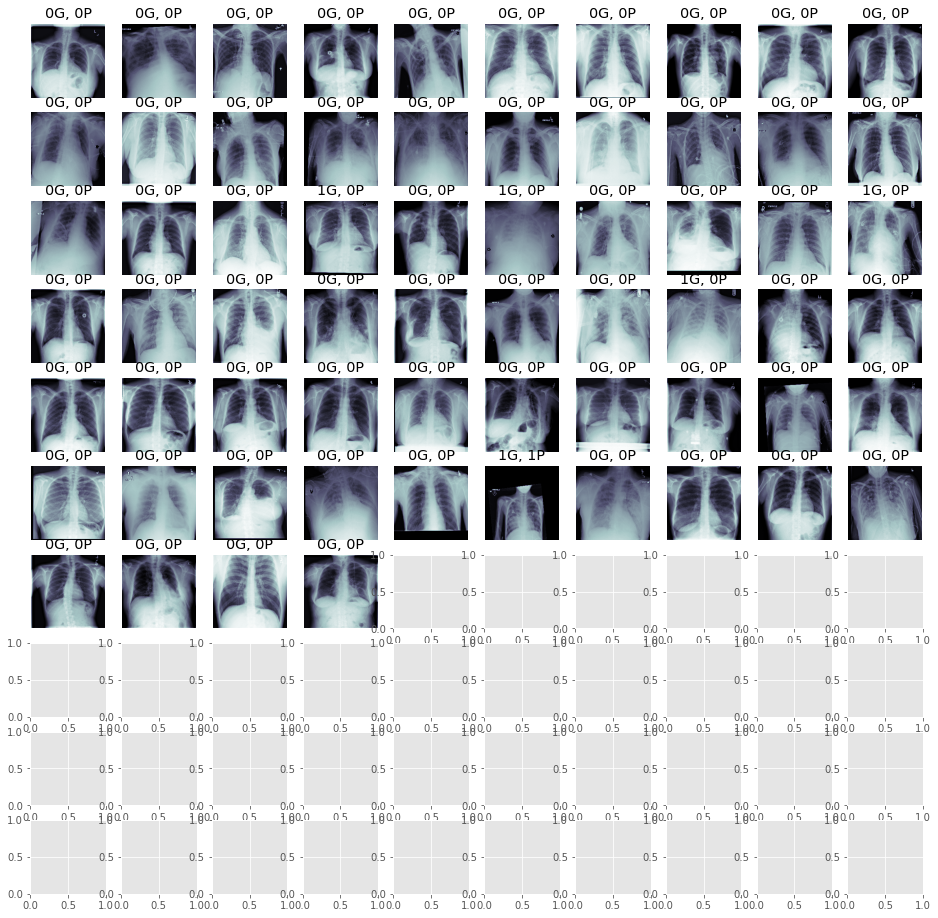

In [31]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1G, 1P')
        else:
            c_ax.set_title('1G, 0P')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0G, 1P')
        else:
            c_ax.set_title('0G, 0P')
    c_ax.axis('off')
    i=i+1

In [32]:
## Just save model architecture to a .json:

model_file = "model.json"
model_json = model.to_json()
with open(model_file, "w") as json_file:
    json_file.write(model_json)